#Tipos de fronteras en clasificación

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

def do_gaussianXOR(n1=250,n2=250):
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test

> **a) Construya el conjunto de datos (*dataset*) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.**

Se define un randomizador que agregara puntos en el plano cartesiano para los cuatro cuadrantes siguiendo una distribución normal con medias entre [-0.5, 0.5] dependiendo del cuadrante en el cual se agregue, además se establece una desviación estandar de 0.3, se distribuyen los puntos en el set de entrenamiento y se establecen a que clase corresponde cada uno en el set y_train, luego se genera un espacio de testing.

In [2]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR()

In [3]:
print("Dimensiones conjunto de entrenamiento: "+ str(X_train.shape))
print("Dimensiones conjunto de pruebas: "+ str(X_test.shape))

Dimensiones conjunto de entrenamiento: (1000, 2)
Dimensiones conjunto de pruebas: (500, 2)


El conjunto de entrenamiento cuenta con 1000 ejemplos bi-dimensionales. El conjunto de pruebas contiene 500 ejemplos.

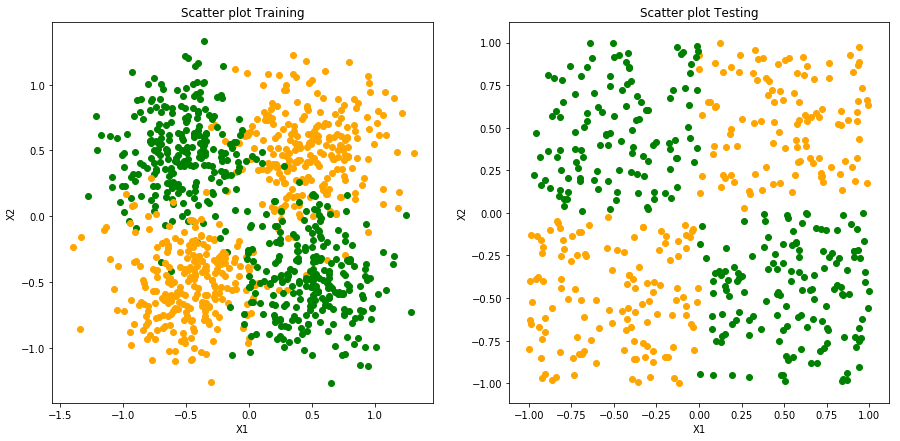

In [4]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title("Scatter plot Training")
plt.xlabel("X1")
plt.ylabel("X2")
for i in range(len(X_train)):
  if Y_train[i] == 0:
    plt.scatter(X_train[i,0],X_train[i,1], c="orange")
  else:
    plt.scatter(X_train[i,0],X_train[i,1], c="green")
plt.subplot(122)
plt.title("Scatter plot Testing")
plt.xlabel("X1")
plt.ylabel("X2")
for i in range(len(X_test)):
  if Y_test[i] == 0:
    plt.scatter(X_test[i,0],X_test[i,1], c="orange")
  else:
    plt.scatter(X_test[i,0],X_test[i,1], c="green")
plt.show()

<font size="5">ACÁ DESCRIPCIÓN DEL GRÁFICO c:</font>

In [5]:
import matplotlib.pyplot as plt
def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(12, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5

    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()

> **b) Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.**

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def do_LDA(X, Y):
  model = LDA()
  model.fit(X, Y)
  return model

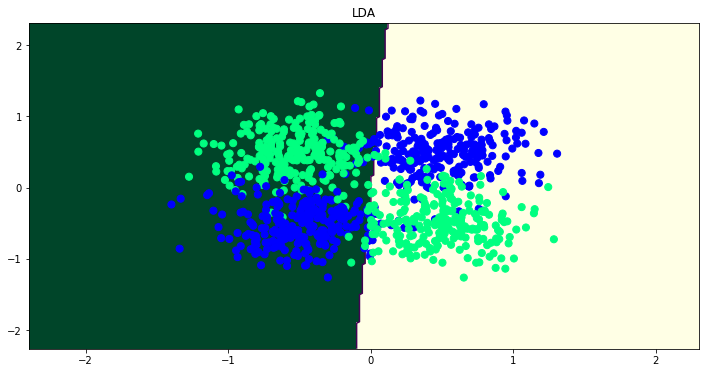

In [7]:
lda = do_LDA(X_train, Y_train)
visualize_border(lda, X_train, Y_train, "LDA")

# COMPLETAR MÁS
Debería tener el mismo comportamiento que un clasificador que elija de manera aleatoria que clase asignar, debido a que se observa que la frontera obtenida clasificará mal aproximadamente el 50% de los datos.

> **c) Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué distribución de probabilidad asumen cada uno?**

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

def do_QDA(X, Y):
  model = QDA()
  model.fit(X, Y)
  return model

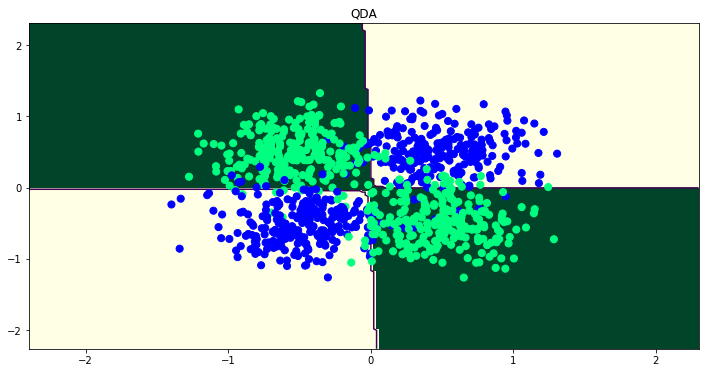

In [9]:
qda = do_QDA(X_train, Y_train)
visualize_border(qda, X_train, Y_train, "QDA")

> **d) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de sklearn. Mediante la widget interactiva explore diferentes valores del parámetro de regularización  $C$. Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el accuracy sobre el conjunto de pruebas. **

In [10]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param, kernel='linear', degree=3):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel=kernel, degree=degree)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
  
from ipywidgets import interactive

def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X_train,Y_train) #here choose train/test or both!
    
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=-1, description='param', max=4, min=-6), Output()), _dom_classes=('widge…

In [11]:
p_min = -6 #define your range
p_max = 4 #define your range
def visualize_border_kernel(param, kernel='linear', degree=3):
    model = train_model(param, kernel, degree)
    visualize_border(model,X_train,Y_train)
    
interactive(visualize_border_kernel,param=(p_min,p_max))

interactive(children=(IntSlider(value=-1, description='param', max=4, min=-6), Text(value='linear', descriptio…

In [12]:
from sklearn.tree import DecisionTreeClassifier as Tree

def train_model_tree(param):
    model = Tree()
    print("Depth= ",param)
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model

def visualize_border_interactive_tree(param):
    model = train_model_tree(param)
    visualize_border(model,X_train,Y_train) #here choose train/test or both!

p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive_tree,param=(p_min,p_max))

interactive(children=(IntSlider(value=20, description='param', max=40, min=1), Output()), _dom_classes=('widge…

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Using TensorFlow backend.


interactive(children=(IntSlider(value=5, description='param', max=10), Output()), _dom_classes=('widget-intera…

# Un problema multilabel

> a) Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?

In [14]:
import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings("ignore")

y1 = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None)
y = y1.values
print(y.shape)
y1.head()

(27807, 81)


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


80?

> b) Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.

Etiquetas de la imagen : ['buildings' 'cityscape' 'clouds' 'road' 'water']


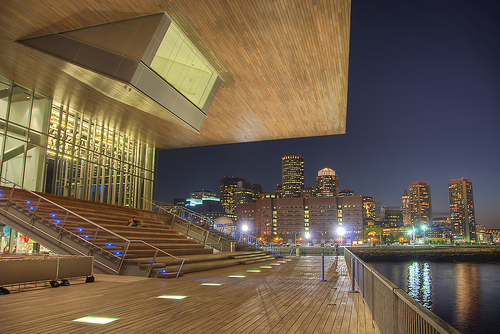

In [15]:
import urllib.request, re

label_names = np.loadtxt("Concepts81.txt",dtype='object')
arch = open("NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()

"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urllib.request.urlopen(data_urls[s]))
im

Multilabel es una extensión del problema de clasificación en el cual un input puede tener un output que es combinación de multiples labels.

En este caso se esta viendo una imagen de un paisaje en el cual existen multiples elementos que lo conforman pero la imagen no se etiqueta como el concepto de tipo de paisaje, sino que etiquetan los elementos que la conforman. Es por esto que una imagen puede tener tantas etiquetas como tipos de objetos conforman la imagen.

> c) Comente sobre la **representación** que posee la salida de los modelos (*labels*) ¿En qué dominio habita? ¿Tiene restricciones?

Cuando se trabaja con un problema de clasificación es necesario representar la salida como un valor numero indicando la clase a la que corresponde el caso, para un caso de clasificación se puede utilizar una notación 0 y 1, para multi clases basta con un valor numerico, en este caso en cambio, se puede utilizar un vector binario marcando un 1 cuando el elemento j del vector se encuentra dentro de la imagen i y 0 cuando no.

SACAR DOM y RESTRICCIONES

> d) Decida sobre una **representación**, en este caso descriptores, para la entrada a los modelos (*input*), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.

*Recuerde que siempre puede optar por muestrear y así achicar los datos de entrenamiento por temas de cómputo*

In [16]:
from sklearn.utils import resample

file = "Normalized_CH_Lite_Train.dat" or "Normalized_CM55_Lite_Train.dat"
descriptors1 = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None)
descriptors, y2 = resample(descriptors1, y, n_samples=10000)
descriptors = descriptors.values
descriptors.shape, y2.shape

((10000, 64), (10000, 81))

> e) Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos.

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(descriptors,y2,test_size=0.33)

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

> f) Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las *labels* que tenga un dato de manera normalizada. Defina **otra** métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).

In [18]:
def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.dot(y,yp) / np.sum(y)  #cantidad de valores iguales
    return suma/float(len(y_true))

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def evaluation_metric2(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

> g) Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender de manera sencilla a *multi-label* [[4]](#refs). Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.

In [19]:
from sklearn.tree import DecisionTreeClassifier as Tree

def do_Tree(depth=10, criterion='gini', splitter='best'):
    model = Tree() 
    model.set_params(max_depth=10,criterion='gini',splitter='best')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return model, y_pred
    

tree, y_pred1 = do_Tree(10, 'entropy', 'best')



In [20]:
print("metrica 1:", evaluation_metric(y_test,y_pred1))
print("metrica 2:", evaluation_metric2(y_test, y_pred1))

metrica 1: nan
metrica 2: 0.060909090909090906


> h) Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender a *multi-label* a través de la técnica **OneVsRest**. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.

In [21]:
from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.multiclass import OneVsRestClassifier

def do_SVM(c = 1, kernel='rbf'):
    model= SVM()
    model.set_params(C=c,kernel=kernel)
    meta_model = OneVsRestClassifier(model)
    meta_model.fit(X_train,y_train)
    y_pred = meta_model.predict(X_test)
    return model, y_pred

svm, y_pred2 = do_SVM(1, 'rbf')

KeyboardInterrupt: 

In [ ]:
print("metrica 1:", evaluation_metric(y_test,y_pred2))
print("metrica 2:", evaluation_metric2(y_test, y_pred2))

> i) Experimente en resolver el problema con una Red Neuronal *Feed Forward* (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a *multi-label* a través de la interfaz de *keras* seleccionando una *loss* adecuada, en este caso **binary cross entropy** ¿Por qué?

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

def do_NFF():
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
    model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=1)
    return model

nff = do_NFF()

In [ ]:
def transform(prob_pred):
    for i in prob_pred:
        for j in range(len(i)):
            if i[j] >= 0.7:
                i[j] = 1
            else:
                i[j] = 0
    return prob_pred

> j)  Realice predicciones **probabilísticas** de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de *labels* categoricos definidos como en c).  
*Hint: Recuerde que el no pertenecer a ninguna *label*/etiqueta es una posibilidad!!*

In [ ]:
prob_pred = nff.predict(X_test)
y_pred3 = transform(prob_pred)
print(prob_pred)

> k) Ahora que recuperó la representación de las *labels* mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.

In [ ]:
print("metrica 1:", evaluation_metric(y_test,y_pred3))
print("metrica 2:", evaluation_metric2(y_test, y_pred3))

# Taxi Trip Duration: Predicción de duración de viaje

In [22]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [28]:
import pandas as pd
df = pd.read_csv("train.zip")
df.info()
output = df['trip_duration'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Se tienen un total de 11 columnas donde la variable a predecir corresponde a trip_duration, los tipos de datos corresponden a tipo objeto, el cual probablemente sea de tipo _date_. Para ver de mejor manera estos tipos de datos se muestran los primeros 5 registros del dataset.

In [29]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Lo objetos mencionados anteriormente corresponden a _timestamps_. Por otro lado, se entregan distintas coordenadas para la latitud y la longitud de origen y destino. Se cree que la variable store_and_fwd_flag podría no ser util, debido a que solo indica si la información se guardo en la memoria local del taxi.

In [34]:
for i in df:
    print("Cantidad de valores únicos "+i+": "+str(len(df[i].unique())))

Cantidad de valores únicos id: 1458644
Cantidad de valores únicos vendor_id: 2
Cantidad de valores únicos pickup_datetime: 1380222
Cantidad de valores únicos dropoff_datetime: 1380377
Cantidad de valores únicos passenger_count: 10
Cantidad de valores únicos pickup_longitude: 23047
Cantidad de valores únicos pickup_latitude: 45245
Cantidad de valores únicos dropoff_longitude: 33821
Cantidad de valores únicos dropoff_latitude: 62519
Cantidad de valores únicos store_and_fwd_flag: 2
Cantidad de valores únicos trip_duration: 7417


In [40]:
print("Vendor ID:")
print(df['vendor_id'].unique())
print("Passenger Count:")
print(df["passenger_count"].unique())


Vendor ID:
[2 1]
Passenger Count:
[1 6 4 2 3 5 0 7 9 8]


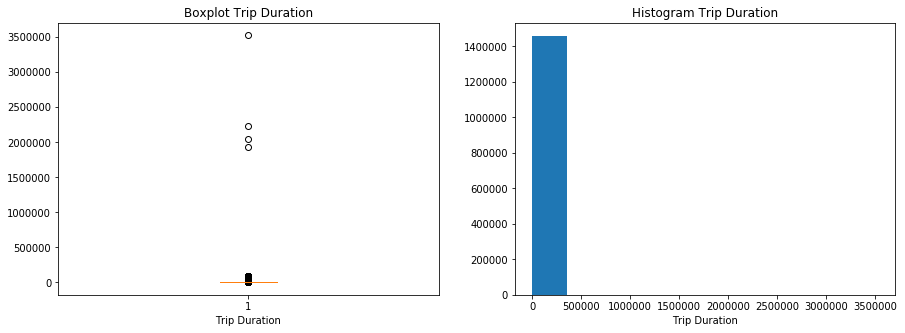

In [43]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Boxplot Trip Duration")
plt.boxplot(output)
plt.xlabel("Trip Duration")
plt.subplot(122)
plt.title("Histogram Trip Duration")
plt.hist(output)
plt.xlabel("Trip Duration")
plt.show()

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

In [48]:
df = df[(df['trip_duration']<=100000)]
output = df['trip_duration'].values
df_new = df

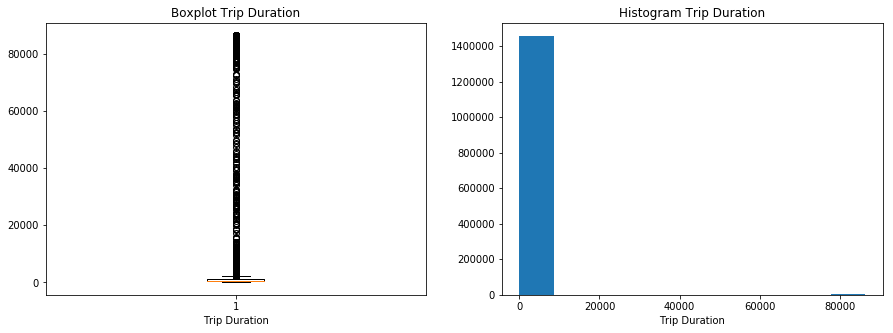

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Boxplot Trip Duration")
plt.boxplot(output)
plt.xlabel("Trip Duration")
plt.subplot(122)
plt.title("Histogram Trip Duration")
plt.hist(output)
plt.xlabel("Trip Duration")
plt.show()

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.  

In [51]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


Se generan nuevas caracteristicas de utilidad a partir de los datos que vienen con el dataset por defecto, se obtiene la distancia entre el punto de recogida y el punto de llegada por medio de la distancia euclidiana utilizando las coordenadas de dichos puntos, luego se calcula la distancia en kilometros por medio de la distancia basada en great_circle la cual se basa en la cual calcula la distancia mínima sobre la superficie de una esfera.

Además con la información del tiempo de recogida y llegada se determina en que época del año, mes, día y hora se realiza el viaje, gracias a esto es posible tomar en cuenta si la hora corresponde a una hora peak y si el día es feriado o no. El caso de la época puede ser de utilidad dado que en días con más lluvia el transito generalmente es más lento.


Se eliminan del dataset columnas que se consideran inutiles para la predicción, estas corresponden a pickup_datetime,dropoff_datetime, id, vendor_id, store_and_fwd_flag.

> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.

In [52]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
#scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Se utilizo RobustScaler debido a los outliers que se presentan en el dataset, este escalador funciona utilizando la mediana y el rango intercuartilico los cuales son estadisticos resistentes a outliers.

In [53]:
print("Conjunto X_training:",X_train_scaled.shape)
print("Conjunto y_train:",y_train.shape)
print("Conjunto X_testing:",X_test_scaled.shape)
print("Conjunto y_test:",y_test.shape)

Conjunto X_training: (1021048, 13)
Conjunto y_train: (1021048,)
Conjunto X_testing: (437592, 13)
Conjunto y_test: (437592,)


El conjunto de entrenamiento posee 1021048 filas de ejemplos con 13 atributos, el conjunto de testing tiene un total de 437592 filas.

In [ ]:
from sklearn.utils import resample

X_train_sample, y_train_sample = resample(X_train_scaled, y_train, frac=0.5)
X_test_sample, y_test_sample = resample(X_test_scaled, y_test, frac=0.5)

In [ ]:
print("Conjunto X_training:",X_train_scaled.shape)
print("Conjunto y_train:",y_train.shape)
print("Conjunto X_testing:",X_test_scaled.shape)
print("Conjunto y_test:",y_test.shape)

> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

In [ ]:
from sklearn.svm import SVR

def do_SVR(X_train, y_train, c=1.0, epsil=0.1):
    model = SVR(C=c, epsilon=epsil) #SVM, Decision Trees or Neural Network
    model.fit(X_train,y_train)
    return model


model = do_SVR(X_train_scaled, y_train)
print("ERROR RMSLE de training: ",rmsle(model.predict(X_train_scaled),y_train))
print("ERROR RMSLE de test: ",rmsle(model.predict(X_test_scaled),y_test))